# MNIST Project

## Imports

In [1]:
import torch
from torch import Tensor 
from torch import nn
from torch import optim
from torch.nn import functional as F
from torch.autograd import Variable
import src.dlc_practical_prologue as prologue
import matplotlib.pyplot as plt

## Loading the Data

In [2]:
def onehot_Y(target):
    '''
    Create one-hot labels for Y
    '''
    res = torch.zeros(target.size(0), 2)
    res[range(target.size(0)), target] = 1
    return res

In [3]:
def onehot_Class(target):
    res = torch.zeros(target.size(0), 10*target.size(1))
    res[range(target.size(0)), target[:, 0]] = 1
    res[range(target.size(0)), target[:, 1] + 10] = 1
    return res

In [7]:
N = 1000
train_X, train_Y, train_Class, test_X, test_Y, test_Class = prologue.generate_pair_sets(N)

In [8]:
#train_Y = onehot_Y(train_Y).long()
#train_Class = onehot_Class(train_Class).long()
#test_Y = onehot_Y(test_Y).long()
#test_Class = onehot_Class(test_Class).long()

In [9]:
%%capture
mu, std = train_X.mean(), train_X.std()
train_X.sub_(mu).div_(std)
test_X.sub_(mu).div_(std)

## Model 1: Naive convnet
For the first model, we create a naive convnet, not taking into account the structrue of the channels.

In [10]:
class convNet(nn.Module):
    def __init__(self):
        super(convNet, self).__init__()
        self.conv1 = nn.Conv2d(2, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.fc1 = nn.Linear(256, 100)
        self.fc2 = nn.Linear(100, 2)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), kernel_size=2, stride=2))
        x = F.relu(F.max_pool2d(self.conv2(x), kernel_size=2, stride=2))
        x = F.relu(self.fc1(x.view(-1, 256)))
        x = self.fc2(x)
        return x

In [57]:
def train_model(model, criterion, optimizer, nb_epochs, minibatch_size, train_X, train_Y, verbose=False, regularization=None):
    for e in range(nb_epochs):
        for b in range(0, train_X.size(0), minibatch_size):
            out = model(train_X.narrow(0, b, minibatch_size))
            loss = criterion(out, train_Y.narrow(0, b, minibatch_size)) 
            if regularization != None:
                for p in model.parameters():
                    loss += regularization * p.abs().sum() / len(p)
                #loss += model.parameters
            model.zero_grad()
            loss.backward()
            optimizer.step()
        if(verbose): print(loss)
    return model

In [58]:
def train_model_path(model, criterion, optimizer, nb_epochs, minibatch_size, train_X, \
                     train_Y, test_X, test_Y, verbose=False, regularization=None):
    train_error = []
    test_error = []
    for e in range(nb_epochs):
        for b in range(0, train_X.size(0), minibatch_size):
            out = model(train_X.narrow(0, b, minibatch_size))
            loss = criterion(out, train_Y.narrow(0, b, minibatch_size))
            if regularization != None:
                for p in model.parameters():
                    loss += regularization * p.abs().sum() / len(p)
            model.zero_grad()
            loss.backward()
            optimizer.step()
        train_error.append(compute_nb_errors(model, train_X, train_Y, minibatch_size))
        test_error.append(compute_nb_errors(model, test_X, test_Y, minibatch_size))
    return model, train_error, test_error

In [13]:
def compute_nb_errors(model, data_input, data_target, minibatch_size):
    nb_data_errors = 0
    for b in range(0, data_input.size(0), minibatch_size):
        out = model(data_input.narrow(0, b, minibatch_size))
        _, pred = torch.max(out.data, 1)
        for k in range(minibatch_size):
            if data_target[b+k] != pred[k]:
                nb_data_errors += 1
    return nb_data_errors

In [14]:
model1 = convNet()
model1, train_path, test_path = train_model_path(model1, nn.CrossEntropyLoss(), optim.SGD(model1.parameters(), lr=1e-1), \
                                                 100, 100, train_X, train_Y, test_X, test_Y, verbose=True)

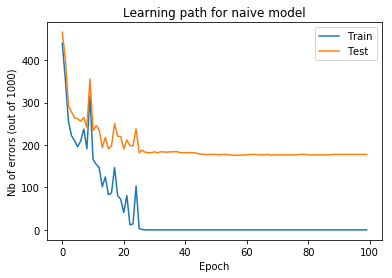

Final Test Error: 178/1000


In [15]:
plt.plot(train_path, label = 'Train')
plt.plot(test_path, label = 'Test')
plt.title('Learning path for naive model')
plt.xlabel('Epoch')
plt.ylabel('Nb of errors (out of 1000)')
plt.legend()
plt.show()
print('Final Test Error: {}/1000'.format(compute_nb_errors(model1, test_X, test_Y, 100)))

We observe that this model does not manage to learn the mapping very well.

## Model 2: Using transfer learning

### Part 1: Study of a good functioning digit detection network for 28x28 images

In [16]:
train_input, train_target, test_input, test_target = \
    prologue.load_data(one_hot_labels = False, normalize = True, flatten = False)

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5)
        self.fc1 = nn.Linear(256, 200)
        self.fc2 = nn.Linear(200, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), kernel_size=3, stride=3))
        x = F.relu(F.max_pool2d(self.conv2(x), kernel_size=2, stride=2))
        x = F.relu(self.fc1(x.view(-1, 256)))
        x = self.fc2(x)
        return x

* Using MNIST
** Reduce the data-set (use --full for the full thing)
** Use 1000 train and 1000 test samples


In [17]:
train_input, train_target = Variable(train_input), Variable(train_target)
model = Net()

In [18]:
model = train_model(model, nn.CrossEntropyLoss(), optim.SGD(model.parameters(), lr=1e-1), 50, 100, train_input, train_target)

In [19]:
print('Final Test Error: {}/1000'.format(compute_nb_errors(model, test_input, test_target, 100)))

Final Test Error: 67/1000


### Part 2: Adapting the network to 14x14 images

In [20]:
# fist, create the training and testing dataset
train_target_14px = torch.cat((train_Class[:,0], train_Class[:,1]))
train_input_14px = torch.cat((train_X[:,0,:,:].view(1000,1,14,14), train_X[:,1,:,:].view(1000,1,14,14)))

test_target_14px = torch.cat((test_Class[:,0], test_Class[:,1]))
test_input_14px = torch.cat((test_X[:,0,:,:].view(1000,1,14,14), test_X[:,1,:,:].view(1000,1,14,14)))

train_input_14px, train_target_14px = Variable(train_input_14px), Variable(train_target_14px)

In [21]:
class Net_14px(nn.Module):
    def __init__(self):
        super(Net_14px, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3) 
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.fc1 = nn.Linear(256, 100)
        self.fc2 = nn.Linear(100, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), kernel_size=2, stride=2)) #image size 12x12-> image size 6x6
        x = F.relu(F.max_pool2d(self.conv2(x), kernel_size=2, stride=2)) #image size 4x4 -> image size 2x2
        x = F.relu(self.fc1(x.view(-1, 256)))
        x = self.fc2(x)
        return x

In [22]:
model_14px = Net_14px()
model_14px, train_path, test_path = train_model_path(model_14px, nn.CrossEntropyLoss(), optim.SGD(model_14px.parameters(), lr=1e-1), 50, 100, \
                         train_input_14px, train_target_14px, test_input_14px, test_target_14px, verbose=True)

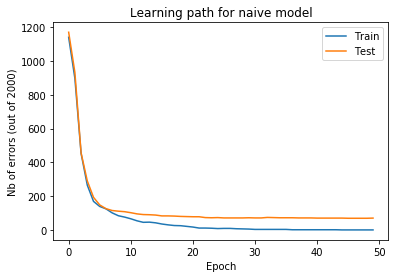

Final Test Error: 70/2000


In [23]:
plt.plot(train_path, label = 'Train')
plt.plot(test_path, label = 'Test')
plt.title('Learning path for naive model')
plt.xlabel('Epoch')
plt.ylabel('Nb of errors (out of 2000)')
plt.legend()
plt.show()
print('Final Test Error: {}/2000'.format(compute_nb_errors(model_14px, test_input_14px, test_target_14px, 100)))


Now, let's define the siamese model with parameter sharing:

In [24]:
class siamese_Net(nn.Module):
    def __init__(self):
        super(siamese_Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3) 
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.fc1 = nn.Linear(256, 100)
        self.fc3 = nn.Linear(200, 10)
        self.fc4 = nn.Linear(10,2)

    def forward(self, x):
        x1 = F.relu(F.max_pool2d(self.conv1(x[:,0,:,:].view(x.size(0),1,14,14)), kernel_size=2, stride=2)) #image size 12x12-> image size 6x6
        x1 = F.relu(F.max_pool2d(self.conv2(x1), kernel_size=2, stride=2)) #image size 4x4 -> image size 2x2
        x1 = F.relu(self.fc1(x1.view(-1, 256)))
        x2 = F.relu(F.max_pool2d(self.conv1(x[:,1,:,:].view(x.size(0),1,14,14)), kernel_size=2, stride=2)) #image size 12x12-> image size 6x6
        x2 = F.relu(F.max_pool2d(self.conv2(x2), kernel_size=2, stride=2)) #image size 4x4 -> image size 2x2
        x2 = F.relu(self.fc1(x2.view(-1, 256)))
        x = F.relu(self.fc3(torch.cat((x1.view(-1,100), x2.view(-1, 100)), 1)))
        x = self.fc4(x)
        return x

In [25]:
sNet = siamese_Net()

In [26]:
torch.save(model_14px.state_dict(), 'networks/model_14px.pt')

In [27]:
sNet.load_state_dict(torch.load('networks/model_14px.pt'), strict=False)

In [28]:
sNet, train_path, test_path = train_model_path(sNet, nn.CrossEntropyLoss(), optim.SGD(sNet.parameters(), lr=1e-1), \
                                                 50, 100, train_X, train_Y, test_X, test_Y, verbose=True)

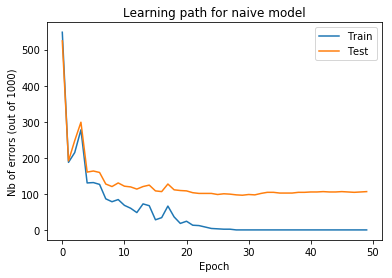

Final Test Error: 107/1000


In [29]:
plt.plot(train_path, label = 'Train')
plt.plot(test_path, label = 'Test')
plt.title('Learning path for naive model')
plt.xlabel('Epoch')
plt.ylabel('Nb of errors (out of 1000)')
plt.legend()
plt.show()
print('Final Test Error: {}/1000'.format(compute_nb_errors(sNet, test_X, test_Y, 100)))

# Model 3: Siamese Net without Pretraining

In [30]:
sNet2 = siamese_Net()

In [31]:
sNet2, train_path, test_path = train_model_path(sNet2, nn.CrossEntropyLoss(), optim.SGD(sNet2.parameters(), lr=1e-1), \
                                                 50, 100, train_X, train_Y, test_X, test_Y, verbose=True)

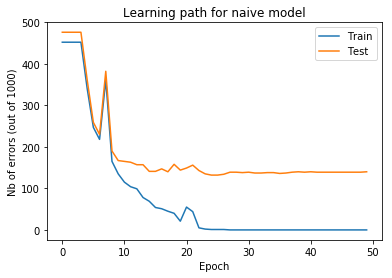

Final Test Error: 140/1000


In [32]:
plt.plot(train_path, label = 'Train')
plt.plot(test_path, label = 'Test')
plt.title('Learning path for naive model')
plt.xlabel('Epoch')
plt.ylabel('Nb of errors (out of 1000)')
plt.legend()
plt.show()
print('Final Test Error: {}/1000'.format(compute_nb_errors(sNet2, test_X, test_Y, 100)))

### ..with weight decay (L1 reg.)

In [45]:
sNet3 = siamese_Net()

In [46]:
sNet3.load_state_dict(torch.load('networks/model_14px.pt'), strict=False)

In [ ]:
for p in sNet3.conv1.parameters():
    p.requires_grad = True
for p in sNet3.conv2.parameters():
    p.requires_grad = True
for p in sNet3.fc1.parameters():
    p.requires_grad = True

for p in sNet3.fc3.parameters():
    p.requires_grad = True
for p in sNet3.fc4.parameters():
    p.requires_grad = True

In [71]:
sNet3, train_path, test_path = train_model_path(sNet3, nn.CrossEntropyLoss(), \
                                                optim.SGD(sNet3.parameters(), lr=4*1e-2), \
                                                150, 100, train_X, train_Y, test_X, test_Y, verbose=True, regularization=0.1)

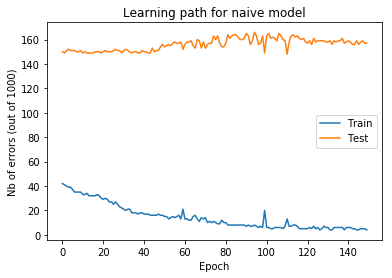

Final Test Error: 157/1000


In [72]:
plt.plot(train_path, label = 'Train')
plt.plot(test_path, label = 'Test')
plt.title('Learning path for naive model')
plt.xlabel('Epoch')
plt.ylabel('Nb of errors (out of 1000)')
plt.legend()
plt.show()
print('Final Test Error: {}/1000'.format(compute_nb_errors(sNet3, test_X, test_Y, 100)))